In [73]:
import os
import plotly.express as px

In [74]:
import os
from pathlib import PosixPath
import random
import matplotlib.pyplot as plt
%matplotlib inline 

import numpy as np
from PIL import Image

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import preprocessing
from tensorflow.keras import callbacks
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers

In [75]:
root_path = '/content/drive/MyDrive/Data/'
data_dir = PosixPath(root_path)

In [76]:
image_count = len(list(data_dir.glob("*/*")))
print(f"Image count: {image_count}")

Image count: 11739


In [77]:
class_names = os.listdir(root_path)
class_names

['Crocodile',
 'Chopper',
 'Kurohige',
 'Luffy',
 'Franky',
 'Law',
 'Jinbei',
 'Brook',
 'Ace',
 'Akainu',
 'Rayleigh',
 'Shanks',
 'Zoro',
 'Robin',
 'Sanji',
 'Usopp',
 'Nami',
 'Mihawk',
 'SplitImages']

In [78]:
class_names.remove('SplitImages')

In [79]:
len(class_names)

18

In [80]:
class_distribution = [len(os.listdir(root_path + name)) for name in class_names]
class_distribution

[651,
 648,
 648,
 654,
 651,
 651,
 651,
 657,
 648,
 651,
 651,
 651,
 659,
 651,
 651,
 648,
 665,
 651]

In [81]:
fig = px.pie(
    names=class_names,
    values=class_distribution,
    width=500,
    hole=0.2,
    title="Class Distribution"
)
fig.update_layout({'title':{'x':0.5}})
fig.show()

In [82]:
seed = random.randint(0,100)
random.seed(seed)
seed = random.randint(0,100)
print(f"Current seed : {seed}")

Current seed : 78


In [83]:
import cv2

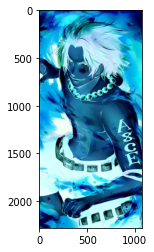

In [84]:
img_array = cv2.imread('/content/drive/MyDrive/Data/Ace/1.jpg_inverted.png')
img_array = cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB)
plt.imshow(img_array)
plt.show()

In [85]:
#!pip install split-folders

In [86]:
#import splitfolders

#splitfolders.ratio(root_path, output="/content/drive/MyDrive/Data/SplitImages", 
                  #  seed=seed, ratio=(.7, .3), 
                  #  group_prefix=None)

In [87]:
train_data_path = '/content/drive/MyDrive/Data/SplitImages/train'
test_data_path = '/content/drive/MyDrive/Data/SplitImages/val'

training_data = []
test_data = []

def create_data(my_data_path,my_data):
    for ct in class_names:
      path = os.path.join(my_data_path,ct)
      class_num = class_names.index(ct)
      for img in os.listdir(path):
        try:
          img_array = cv2.imread(os.path.join(path,img))
          img_array = cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB)
          img_array = cv2.resize(img_array, (100, 100))
          my_data.append([img_array,class_num])
        except Exception as e:
          pass

In [88]:
batch_size = 32
img_size = 100

In [89]:
from keras.preprocessing.image import ImageDataGenerator

In [90]:
datagen = ImageDataGenerator(rescale=1/255.,
                             zoom_range=0.2,
                             horizontal_flip=True)
    
test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = datagen.flow_from_directory(train_data_path,  
                                                target_size=(img_size, img_size), 
                                                batch_size=batch_size,
                                                shuffle=True,
                                                subset='training',
                                                class_mode='categorical')  

test_generator = test_datagen.flow_from_directory(test_data_path,
                                                 target_size=(img_size, img_size),
                                                 batch_size=batch_size,
                                                 shuffle=False,
                                                 class_mode='categorical')

Found 8204 images belonging to 18 classes.
Found 3533 images belonging to 18 classes.


In [91]:
create_data(train_data_path,training_data)
create_data(test_data_path,test_data)

In [92]:
random.shuffle(training_data)

In [93]:
len(training_data)

8204

In [94]:
# def list_splitter(list_to_split, ratio):
#     elements = len(list_to_split)
#     middle = int(elements * ratio)
#     return [list_to_split[:middle], list_to_split[middle:]]

# train_data, val_data = list_splitter(training_data, .9)

In [95]:
# len(train_data)

In [96]:
# len(val_data)

In [97]:
x = []
y = []

for features, label in training_data:
  x.append(features)
  y.append(label)
  
x_test = []
y_test = []

for features, label in test_data:
  x_test.append(features)
  y_test.append(label)

# x_val = []
# y_val = []

# for features, label in val_data:
#   x_test.append(features)
#   y_test.append(label)

In [98]:
y = np.array(y)
y_test = np.array(y_test)
# y_val = np.array(y_val)

x = np.array(x)
x_test = np.array(x_test)
# x_val = np.array(x_val)

x = np.array(x).reshape(-1, img_size, img_size, 3)
x_test = np.array(x_test).reshape(-1, img_size, img_size, 3)
# x_val = np.array(x_val).reshape(-1, img_size, img_size, 3)

In [99]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stopping_monitor = EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=25, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

best_model = ModelCheckpoint('/content/drive/MyDrive/bestmodel.hdf5', monitor='accuracy', save_best_only=True)
best_val_acc = ModelCheckpoint('/content/drive/MyDrive/best_val_acc.hdf5', monitor='val_accuracy', save_best_only=True)

data_augmentation = Sequential(
    layers=[
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=(img_size,img_size,3)),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.1), 
        ], 
    name="data_augmentation"
    )

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.utils import to_categorical

model = Sequential()

model.add(data_augmentation)

model.add(Conv2D(16, (3, 3), kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(img_size, img_size, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(16, (3, 3), kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(18, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.01, decay=1e-6)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


# from keras.utils import to_categorical
y_one_hot=to_categorical(y)
# y_val_one_hot=to_categorical(y_val)

# ***Do not use shuffle and validation split same time or else val_acc: 0.0000e+00***

In [100]:
hist = model.fit(x, y_one_hot, validation_split=.1, verbose=2, epochs=125, batch_size=128, callbacks=[
    early_stopping_monitor,
    learning_rate_reduction,
    best_model, best_val_acc])

Epoch 1/125
58/58 - 47s - loss: 2.9922 - accuracy: 0.0866 - val_loss: 5.4961 - val_accuracy: 0.0633 - lr: 0.0100 - 47s/epoch - 804ms/step
Epoch 2/125
58/58 - 44s - loss: 2.7462 - accuracy: 0.1338 - val_loss: 3.4355 - val_accuracy: 0.0914 - lr: 0.0100 - 44s/epoch - 753ms/step
Epoch 3/125
58/58 - 44s - loss: 2.6703 - accuracy: 0.1562 - val_loss: 2.6777 - val_accuracy: 0.1620 - lr: 0.0100 - 44s/epoch - 756ms/step
Epoch 4/125
58/58 - 45s - loss: 2.6281 - accuracy: 0.1784 - val_loss: 2.9310 - val_accuracy: 0.1169 - lr: 0.0100 - 45s/epoch - 774ms/step
Epoch 5/125
58/58 - 44s - loss: 2.5966 - accuracy: 0.1864 - val_loss: 3.0127 - val_accuracy: 0.1084 - lr: 0.0100 - 44s/epoch - 752ms/step
Epoch 6/125
58/58 - 44s - loss: 2.5765 - accuracy: 0.1934 - val_loss: 2.6957 - val_accuracy: 0.1766 - lr: 0.0100 - 44s/epoch - 761ms/step
Epoch 7/125
58/58 - 45s - loss: 2.5512 - accuracy: 0.2045 - val_loss: 2.6768 - val_accuracy: 0.1608 - lr: 0.0100 - 45s/epoch - 771ms/step
Epoch 8/125
58/58 - 43s - loss: 2.

In [101]:
def visualization(name,h,color):
  t = h.history[name]
  my_max = max(t)
  my_min = min(t)
  print(f'Name : {name} max : {my_max} min : {my_min}')
  plt.plot(t,color=color,linewidth=3.0)
  plt.title(name)
  plt.ylabel(name)
  plt.xlabel('Epoch')
  plt.legend([name],loc='upper left')
  plt.show()

Name : accuracy max : 0.3100365698337555 min : 0.08655018359422684


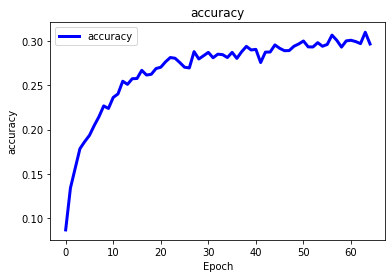

Name : loss max : 2.992206335067749 min : 2.2632436752319336


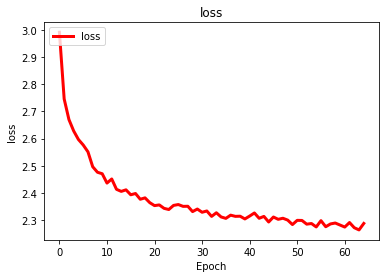

Name : val_accuracy max : 0.38124239444732666 min : 0.06333739310503006


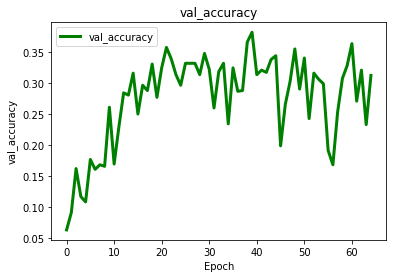

Name : val_loss max : 5.4961323738098145 min : 2.127161741256714


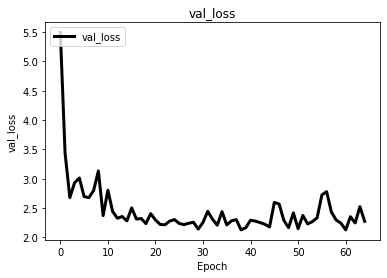

In [102]:
visualization('accuracy',hist,'Blue')
visualization('loss',hist,'Red')
visualization('val_accuracy',hist,'Green')
visualization('val_loss',hist,'Black')

In [103]:
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

In [104]:
model.load_weights('/content/drive/MyDrive/bestmodel.hdf5')
yt_one_hot=to_categorical(y_test)
res = model.evaluate(x_test, yt_one_hot)
print("test loss, test acc:", res)

111/111 [==============================] - 5s 47ms/step - loss: 2.4531 - accuracy: 0.2460
test loss, test acc: [2.453094482421875, 0.2459665983915329]


In [105]:
def my_predict(my_model,my_x_test):
  y_pred = my_model.predict(my_x_test)
  return y_pred

def my_f1_score(my_y_test,my_y_pred):
  f1 = f1_score(my_y_test, my_y_pred, average="micro")
  return f1
  
def my_conf_matrix(my_y_test,my_y_pred):
  cm = confusion_matrix(my_y_test, my_y_pred)
  cm_norm = np.round(cm/np.sum(cm,axis=1).reshape(-1,1),2)
  sns.heatmap(cm_norm,cmap='Greens',annot=True,
              cbar_kws={'orientation' : 'vertical','label' : 'Color bar'},
              fmt='.2f'
              )
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

0.24596660062270026


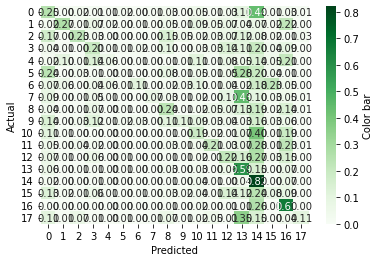

In [106]:
y_pred_res = my_predict(model,x_test)
y_pred_res = np.argmax(y_pred_res, axis=-1)
print(my_f1_score(y_test,y_pred_res))
my_conf_matrix(y_test,y_pred_res)

In [107]:
model.load_weights('/content/drive/MyDrive/best_val_acc.hdf5')
res = model.evaluate(x_test, yt_one_hot)
print("test loss, test acc:", res)

111/111 [==============================] - 5s 47ms/step - loss: 2.1625 - accuracy: 0.3524
test loss, test acc: [2.162519931793213, 0.3523917496204376]


0.3523917350693462


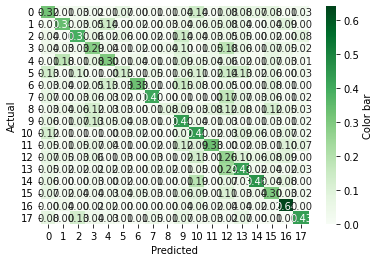

In [108]:
y_pred_res = my_predict(model,x_test)
y_pred_res = np.argmax(y_pred_res, axis=-1)
print(my_f1_score(y_test,y_pred_res))
my_conf_matrix(y_test,y_pred_res)

In [109]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, 100, 100, 3)      0         
 al)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 98, 98, 16)        448       
                                                                 
 batch_normalization_6 (Batc  (None, 98, 98, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 49, 49, 16)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 49, 49, 16)        0         
                                                      

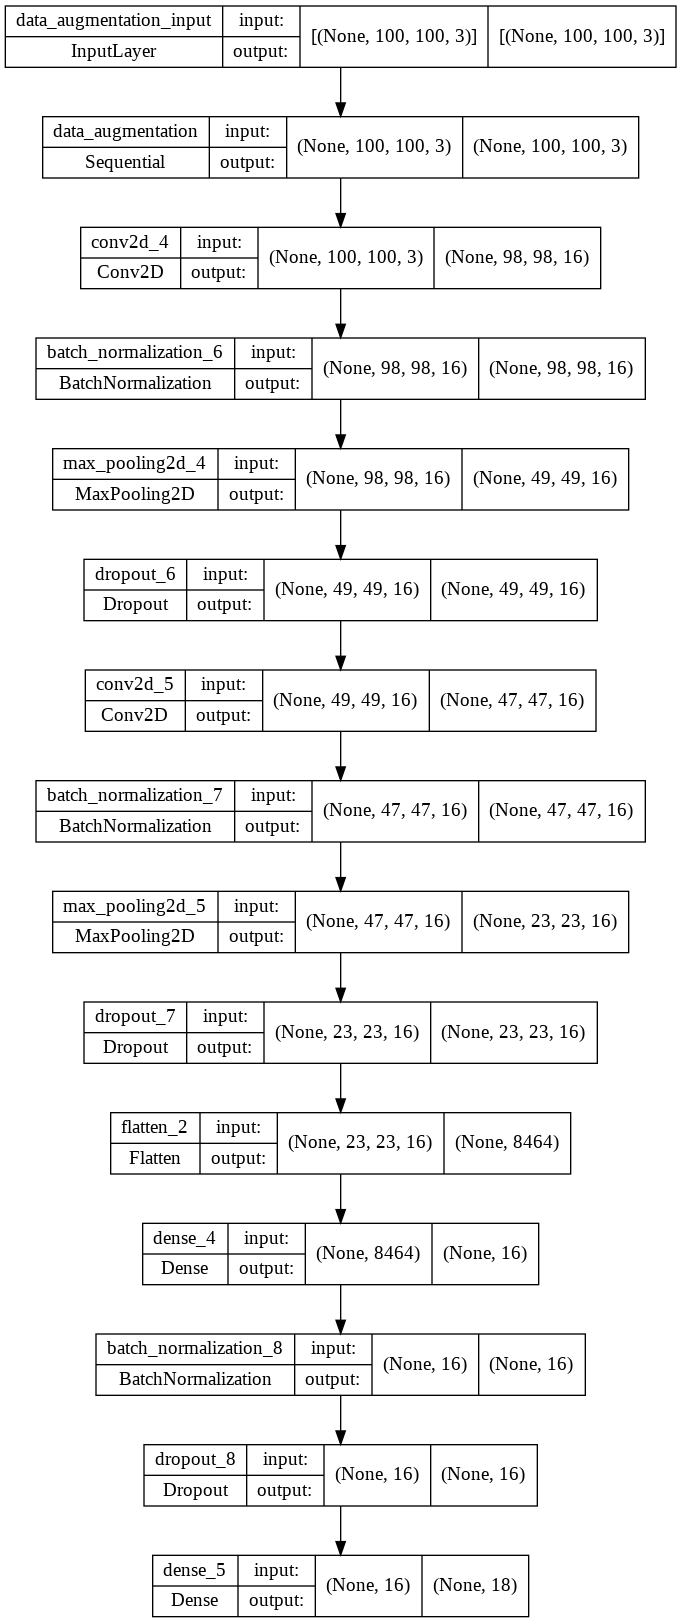

In [110]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [111]:
model.evaluate(x=x_test, return_dict=True)

111/111 [==============================] - 0s 1ms/step - loss: 0.0474 - accuracy: 0.0000e+00


{'loss': 0.04742131754755974, 'accuracy': 0.0}